## optuna with MLFLOW 
- Optuna와 MLFLow를 연동하는 코드를 작성한다. 
- 시각화 코드는 생략한다. 
- MLFLow에서 모델을 불러와서 예측을 진행한다. 
- 예측 결괏값을 제출한다. 

## 라이브러리 불러오기
- 주요 라이브러리를 불러온다. 

In [13]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sklearn
import seaborn as sns
import mlflow 
import mlflow.sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, accuracy_score
import optuna

import xgboost
from xgboost import XGBClassifier

import time

print(f"numpy version {np.__version__}")
print(f"pandas version {pd.__version__}")
print(f"matplotlib version {mpl.__version__}")
print(f"seaborn version {sns.__version__}")
print(f"sklearn version {sklearn.__version__}")
print(f"MLFlow version {mlflow.__version__}")
print(f"optuna version {optuna.__version__}")
print(f"xgboost version {xgboost.__version__}")

numpy version 1.26.1
pandas version 2.1.1
matplotlib version 3.8.0
seaborn version 0.13.0
sklearn version 1.3.1
MLFlow version 2.7.1
optuna version 3.4.0
xgboost version 2.0.0


## 데이터 불러오기
- 데이터는 캐글에서 가져왔다. 
    + 참조 : https://www.kaggle.com/competitions/titanic

In [14]:
DATA_PATH = "C:\\Users\\MSYUN\\Desktop\\ml_optuna_mlflow\\data\\titanic\\"
# DATA_PATH = "각자의 경로를 지정합니다."

train_df = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "gender_submission.csv")

train_df.shape, test.shape, submission.shape

((891, 12), (418, 11), (418, 2))

## 데이터 전처리
- 데이터 전처리는 다음과 같이 진행하였다. 
- 우선, Name 피처에서 각 호칭을 출력한다(Miss, Mr, Mrs 등). 그 후에 각 호칭을 그룹화 하였다. 

In [15]:
train_df['Initial'] = 0
test['Initial'] = 0
for _ in [train_df, test]:
    train_df['Initial'] = train_df['Name'].str.extract('([A-Za-z]+)\.') 
    test['Initial'] = test['Name'].str.extract('([A-Za-z]+)\.') 

b4_title    = ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona']
after_title = ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Miss']

train_df['Initial'] = train_df['Initial'].replace(b4_title, after_title)
test['Initial'] = test['Initial'].replace(b4_title, after_title)

train_df.shape, test.shape

((891, 13), (418, 12))

- 결측치별로 그룹간의 평균을 추가했다. 
- 각 숫자는 각 그룹에 대한 평균 나이임을 기억한다. 
- 그 외 결측치는 수치는 평균, 범주는 최빈도를 대체 했다. 

In [16]:
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Mr'),'Age']=33
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Mrs'),'Age']=36
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Master'),'Age']=5
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Miss'),'Age']=22
train_df.loc[(train_df['Age'].isnull())&(train_df['Initial']=='Other'),'Age']=46

test.loc[(test['Age'].isnull())&(test['Initial']=='Mr'),'Age']=33
test.loc[(test['Age'].isnull())&(test['Initial']=='Mrs'),'Age']=39
test.loc[(test['Age'].isnull())&(test['Initial']=='Master'),'Age']=8
test.loc[(test['Age'].isnull())&(test['Initial']=='Miss'),'Age']=22
test.loc[(test['Age'].isnull())&(test['Initial']=='Other'),'Age']=43

# Fare Mean
test['Fare'] = test['Fare'].fillna(np.mean(test['Fare']))

# Embarked
train_df['Embarked'] = train_df['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

train_df.shape, test.shape

((891, 13), (418, 12))

- 학습 때 참고하지 않을 변수들을 제거했다. 
- 그 외 범주는 원-핫 인코딩으로 수치화 하였다. 

In [17]:
col = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_df = train_df.drop(col, axis=1)
train_df = pd.get_dummies(train_df)

test = test.drop(col, axis=1)
test = pd.get_dummies(test)

train_df.shape, test.shape

((891, 16), (418, 15))

- 결측치가 존재하는지 확인한다. 
- 문자 데이터가 있는지 확인한다. 

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   Sex_female      891 non-null    bool   
 7   Sex_male        891 non-null    bool   
 8   Embarked_C      891 non-null    bool   
 9   Embarked_Q      891 non-null    bool   
 10  Embarked_S      891 non-null    bool   
 11  Initial_Master  891 non-null    bool   
 12  Initial_Miss    891 non-null    bool   
 13  Initial_Mr      891 non-null    bool   
 14  Initial_Mrs     891 non-null    bool   
 15  Initial_Other   891 non-null    bool   
dtypes: bool(10), float64(2), int64(4)
memory usage: 50.6 KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          418 non-null    int64  
 1   Age             418 non-null    float64
 2   SibSp           418 non-null    int64  
 3   Parch           418 non-null    int64  
 4   Fare            418 non-null    float64
 5   Sex_female      418 non-null    bool   
 6   Sex_male        418 non-null    bool   
 7   Embarked_C      418 non-null    bool   
 8   Embarked_Q      418 non-null    bool   
 9   Embarked_S      418 non-null    bool   
 10  Initial_Master  418 non-null    bool   
 11  Initial_Miss    418 non-null    bool   
 12  Initial_Mr      418 non-null    bool   
 13  Initial_Mrs     418 non-null    bool   
 14  Initial_Other   418 non-null    bool   
dtypes: bool(10), float64(2), int64(3)
memory usage: 20.5 KB


## 데이터 셋 분리 
- 다음 코드는 클래스가 불균형일 때 적용할 수 있는 코드다. 
- 데이터가 골고루 섞일 수 있도록 하는 코드로 응용해서 사용하길 바라며, 6:2:2 형태로 구현하였다. 
- 그러나 본 튜토리얼에서는 검증은 생략한다. 

In [20]:
deceased = train_df[train_df['Survived'] == 0].sample(frac=0.5, random_state=42).reset_index(drop=True)
survived = train_df[train_df['Survived'] == 1]

deceased_train, deceased_test = train_test_split(deceased, test_size = 0.2, random_state=42)
survived_train, survived_test = train_test_split(survived, test_size = 0.2, random_state=42)

deceased_train, deceased_validate = train_test_split(deceased_train, test_size = 0.25, random_state=42)
survived_train, survived_validate = train_test_split(survived_train, test_size = 0.25, random_state=42)

X_train = pd.concat((deceased_train, survived_train))
X_test = pd.concat((deceased_test, survived_test))
X_validate = pd.concat((deceased_validate, survived_validate))

y_train = np.array(X_train["Survived"])
y_test = np.array(X_test["Survived"])
y_validate = np.array(X_validate["Survived"])

X_train = X_train.drop("Survived", axis = 1)
X_test = X_test.drop("Survived", axis = 1)
X_validate = X_validate.drop("Survived", axis = 1)

X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((368, 15), (124, 15), (124, 15), (368,), (124,), (124,))

## ML모델 정의
- 머신러닝 알고리즘을 XGBoost를 선택했다. 
- Python에서 XGBoost는 크게 2가지 방법이 존재한다. 
    + Python API 방식으로, 데이터를 DMatrix 방식으로 변환해야 한다. 
    + Scikit-Learn API 방식은, 기존 Scikit-Learn과 동일하게 사용할 수 있다. 
- 본 튜토리얼에서는 Scikit-Learn API 방식으로 기술한다. 
- 파라미터에 대한 설명은 생략한다. 
    + 궁금하신 분들은 공식문서를 참조한다. 
    + 참조 : https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
- 다음 사용자 정의 함수는 크게 2가지로 정의한다. 
    + 첫번째는 모형을 생성하는 코드이다. 이 때 모형을 정의하는 것이며, 모형을 2개 이상 추가할 수 있다. 
    + 두번째는 모형을 학습 시키고 1차 결과를 출력하는 것이다. 앞서 정의한 함수를 가져와서 사용한다. 이 때 두 함수의 매개는 `trial`로 구성되고 있는 것을 확인한다. 또한, 여기에서 1차 평가지표를 산출할 수 있다. 이 평가지표가 추후 MLFlow에 저장될 것이다. 
    

In [21]:
def create_model(trial):
    params = {'eta' : trial.suggest_uniform('eta', 0.0001, 0.1), 
              'max_depth' : trial.suggest_int('max_depth', 2, 10), 
              'subsample': trial.suggest_uniform('subsample', 0.5, 0.9)
             }
    model = XGBClassifier(**params, random_state=42)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

- `Optuna`는 `Study` 객체를 기반으로 움직인다. 
- 이 객체에서는 일종의 실험 이름을 지정할 수 있다. 추후 MLFLow에 해당 이름이 저장이 된다. 
- direction은 일종의 모형의 방향성인데, 예를 들면 정확도는 높을수록 좋기 때문에, direction은 maximize로 지정하며, 만약 회귀문제처럼, 오차가 적으면 좋은 지표는 minimize를 선택하면 된다. 
    + 그 외에도 여러 최적화 방법을 사용할 수 있지만, 여기에서는 우선 생략한다. 
- 시간 측정을 진행했다. 

In [22]:
study = optuna.create_study(study_name='titanic_experiment', direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-11-01 16:53:53,739] A new study created in memory with name: titanic_experiment
C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\3161967853.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  params = {'eta' : trial.suggest_uniform('eta', 0.0001, 0.1),
C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\3161967853.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 0.9)
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\

- Best Parameters를 찾는다. 

In [23]:
print(study.best_trial.params)

{'eta': 0.09657144001713329, 'max_depth': 6, 'subsample': 0.6828832103117}


- 각 파라미터는 Dictionary로 구성되어 있기 때문에, key값을 이용해서 다시 재 학습을 했다. 
- 예측을 통해 실제 Y값을 출력한다. 

In [24]:
best_opt = XGBClassifier(eta = study.best_trial.params['eta'], 
                         max_depth = study.best_trial.params['max_depth'], 
                         subsample = study.best_trial.params['subsample'], 
                         random_state=42)

best_opt.fit(X_train, y_train)
preds = best_opt.predict(X_test)
print(preds)

[0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 0 1 1 1]


C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype)

- 이제 ROC Curve와 오차행렬 그래프를 작성하는 함수를 구현했다. 

In [25]:
def classification_plot(y_test, preds):
    conf_matrix = confusion_matrix(y_test, preds)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    RocCurveDisplay.from_predictions(y_test, preds, name='Scikit-Learn ROC Curve', ax=ax[0])
    ax[0].plot([0, 1], ls='--')
    ax[1] = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].set_ylabel('Actual')
    ax[1].set_xlabel('Predicted')
    ax[1].set_title('Confusion Matrix')
    
    plt.show()

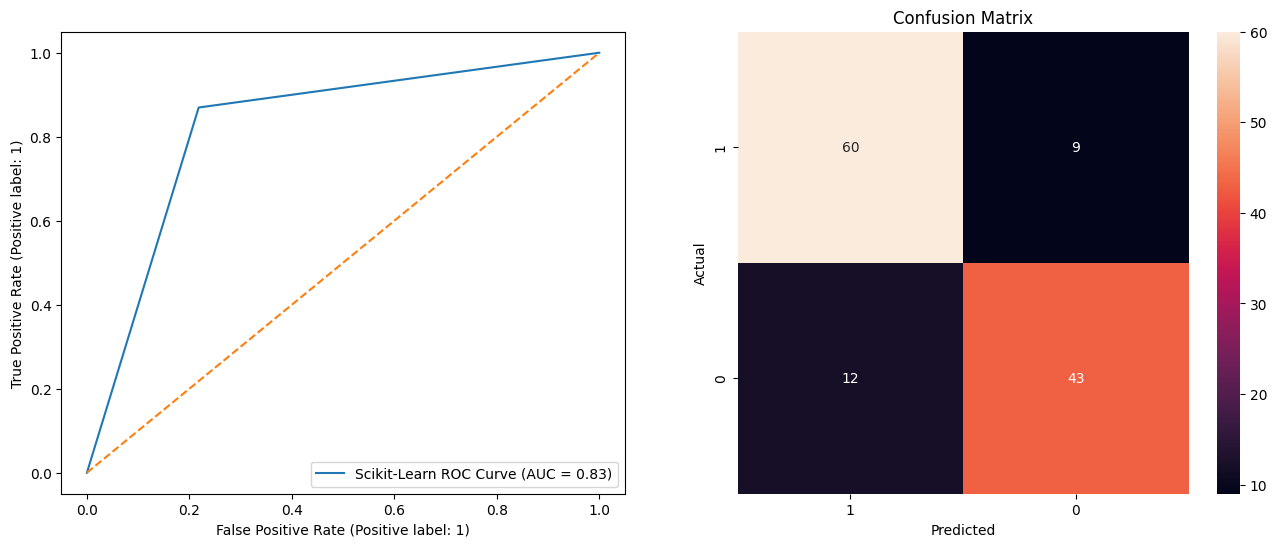

In [26]:
classification_plot(y_test, preds)

## MLFlow 연동
- 이제 MLFlow에 연동한다. MLFLow를 연동하면, 앞서 출력한 코드들을 그대로 MLFLow에 저장하여 기록할 수 있다. 

In [27]:
from optuna.integration.mlflow import MLflowCallback

mlflc = MLflowCallback(
    tracking_uri = 'mlruns', 
    metric_name = 'accuracy'
)

def create_model(trial):
    params = {'eta' : trial.suggest_uniform('eta', 0.0001, 0.1), 
              'max_depth' : trial.suggest_int('max_depth', 2, 10), 
              'subsample': trial.suggest_uniform('subsample', 0.5, 0.9)
             }
    model = XGBClassifier(**params, random_state=42)
    
    mlflow.log_param('eta', params['eta'])
    mlflow.log_param('max_depth', params['max_depth'])
    mlflow.log_param('subsample', params['subsample'])
    
    return model

@mlflc.track_in_mlflow()
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric('auc_score', auc_score)
    mlflow.xgboost.log_model(model, 'xgboost')
    
    mlflow.end_run()
    return accuracy

C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\1489621800.py:3: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\1489621800.py:21: ExperimentalWarning: track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.
  @mlflc.track_in_mlflow()


In [28]:
study = optuna.create_study(study_name='titanic_experiment', direction='maximize')
study.optimize(objective, n_trials=10, callbacks=[mlflc])

[I 2023-11-01 16:53:57,369] A new study created in memory with name: titanic_experiment
2023/11/01 16:53:57 INFO mlflow.tracking.fluent: Experiment with name 'titanic_experiment' does not exist. Creating a new experiment.
C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\1489621800.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  params = {'eta' : trial.suggest_uniform('eta', 0.0001, 0.1),
C:\Users\MSYUN\AppData\Local\Temp\ipykernel_7240\1489621800.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 0.9)
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a 

## 제출
- MLflow UI화면에서 모델을 불러온 후 제출

In [32]:
ml_run_id = 'runs:/94696cc4ff274ac990ec0144af9e65b8/xgboost'
loaded_model = mlflow.xgboost.load_model(ml_run_id)

final_preds = loaded_model.predict(test)
submission['Survived'] = final_preds
submission.to_csv(DATA_PATH + '0809_submission.csv', index=False)

C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype)